In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100
})



from Finite_volume_method_1D import *

In [3]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID3_96dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 300
tau_trickle = 1 # for tau=0.13 => no effect of eta_pb, for tau=1, significant effect
dtinit=0.001
dxfrac=1/4

lambdasinnm = [402,673,986,1545]

KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=False)
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=200,showplots=False)

In [4]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls) # use the same linear decay rate for all wavelengths

194.88850185176454 2.2767849027049727
0.005131139038467322
201.89787714954562 3.9613091250212302
0.004952999081111193
191.8028632586559 3.097737438872922
0.005213686506084371
190.54199588046978 6.5199494193543215
0.0052481868649435


In [7]:
def prep_data(neg_offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(neg_offset,neg_offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+neg_offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,sigma,Q0,dthetadN):
    print('sigma (um):\t',sigma)
    print('Q0 (um-1):\t',Q0)
    print('dthetadN:\t',dthetadN)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=consts.eta_pb_max,sigma_IC=sigma,trickle_time=tau_trickle,Q0=Q0,dthetadN=dthetadN,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def par_func_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False)
     return SIM

def lambda_correction_factor_eta(lambdanm,lambdasinnm):
    mean = np.mean(lambdasinnm)+300
    return (mean/lambdanm)

def lambda_correction_factor_tau(lambdanm,lambdasinnm):
    mean = np.mean(lambdasinnm)-500
    return (mean/lambdanm)


def plotsim(sigma,Q0,dthetadN,factoreta,factortau):
    if factoreta==0:
        datalist = Parallel(n_jobs=4)(delayed(par_func_plot)(KID_params(eta_pb=consts.eta_pb_max,sigma_IC=sigma,trickle_time=tau_trickle,Q0=Q0,dthetadN=dthetadN,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    else:
        print('factor:')
        for lambdanm in lambdasinnm:
            print(factoreta*lambda_correction_factor_eta(lambdanm,lambdasinnm),'\t',factortau*lambda_correction_factor_eta(lambdanm,lambdasinnm))
        datalist = Parallel(n_jobs=4)(delayed(par_func_plot)(KID_params(eta_pb=consts.eta_pb_max*factoreta*lambda_correction_factor_eta(lambdanm,lambdasinnm),sigma_IC=sigma,trickle_time=tau_trickle*factortau*lambda_correction_factor_eta(lambdanm,lambdasinnm),Q0=Q0,dthetadN=dthetadN,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [ ]:
xfit,yfit=prep_data(-1) #-5 means take 5 data points before the max into account for the data
#popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.5,1.3,1],bounds=[[0.1,dtinit,0.1],[length/2,np.inf,np.inf]])
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.5,1,0.5],bounds=[[0.1,0.1,0],[length/2,np.inf,np.inf]])
print('Done!')

In [ ]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['sigma','Q0','dthetadN']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

#Output:
'''
Parameters:
sigma:	2.6449868182	+/-	0.3454672216
Q0:	0.1001772273	+/-	0.0080324761
dthetadN:	0.0003159587	+/-	0.0000146828

Correlation Coefficients:
sigma vs Q0: -0.7848166917
sigma vs dthetadN: 0.0209269580
Q0 vs dthetadN: -0.5672492757
'''

In [ ]:
'''
Parameters:
sigma:	2.6449868182	+/-	0.3454672216
Q0:	0.1001772273	+/-	0.0080324761
dthetadN:	0.0003159587	+/-	0.0000146828

Correlation Coefficients:
sigma vs Q0: -0.7848166917
sigma vs dthetadN: 0.0209269580
Q0 vs dthetadN: -0.5672492757
'''

factor:
1.990544776119403 	 2.9888059701492535
1.1890029717682022 	 1.785289747399703
0.8115608519269778 	 1.2185598377281948
0.5179281553398059 	 0.7776699029126214
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Iteration: 4627	Simtime (us): 300.33117915238753
Iteration: 5218	Simtime (us): 300.11966378021697ime (us): 272.73835418895845
Iteration: 4078	Simtime (us): 300.40756448257326
Iteration: 4569	Simtime (us): 300.34757

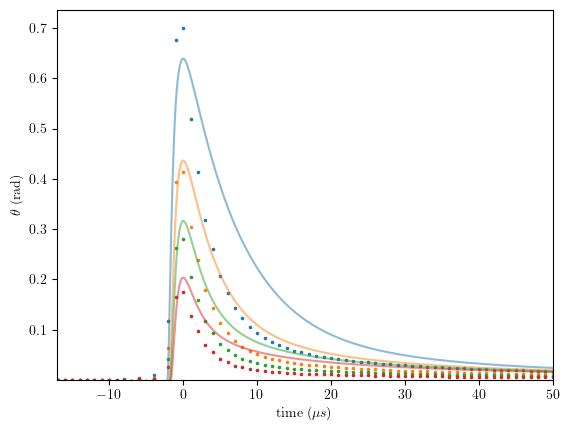

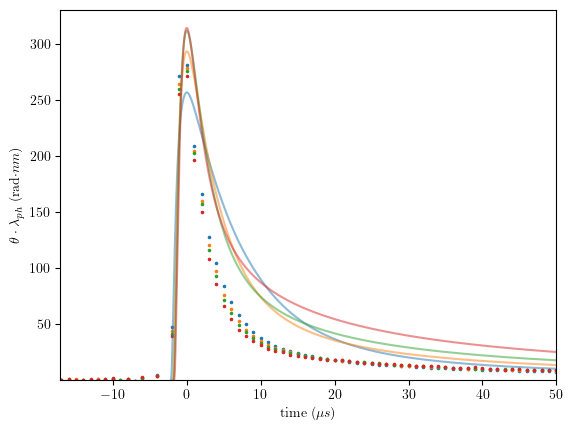

In [11]:
simdata = plotsim(2.6449868182,0.1001772273,0.0003159587,0.666,1)
lambdasinnm = [402,673,986,1545]
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.ylim(1e-3)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.semilogy()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5)
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.ylim(1e-3)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.semilogy()
plt.show()

Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Warning! When using a trickle_time, sigma_IC must be small enough compared to absorber length. Otherwise qps are 'lost' outside the borders of the domain.
Iteration: 2931	Simtime (us): 300.19955323079812
Iteration: 3507	Simtime (us): 300.08902941768196
Iteration: 4035	Simtime (us): 300.06974934511376
Iteration: 4736	Simtime (us): 300.03751153407893


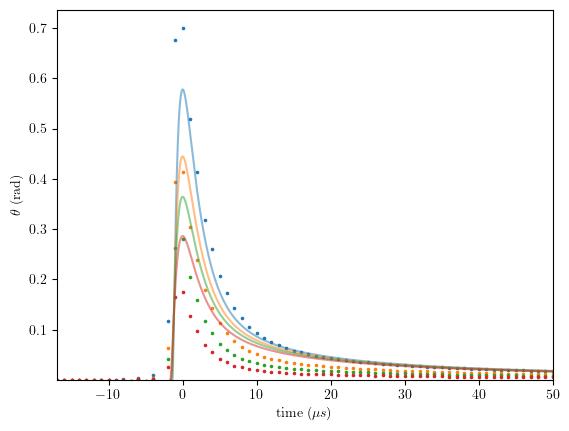

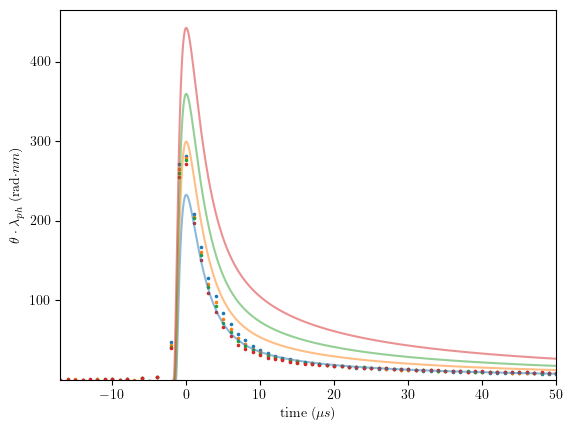

In [34]:
simdata = plotsim(2.6449868182,0.1001772273,0.0003159587,0,0)
lambdasinnm = [402,673,986,1545]
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.ylim(1e-3)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.semilogy()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5)
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.ylim(1e-3)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.semilogy()
plt.show()